In [1]:
from scipy.special import hankel1 as hk
from Solver import *
from q_method import *
from scipy.optimize import minimize
def Integral_Kernel(N,k):
    l = np.linspace(0,1,N+1)
    X_ABS, Y_ABS = np.meshgrid(l, l, indexing='ij')
    HANKEL_BENCHMARK = -1j/4*hk(0,k*np.sqrt(X_ABS**2+Y_ABS**2))
    l1 = np.arange(N+1)
    X1, Y1, X2, Y2 = np.meshgrid(l1, l1, l1, l1, indexing='ij')
    G = HANKEL_BENCHMARK[np.abs(X1-X2),np.abs(Y1-Y2)]
    G[np.isnan(G)] = (2*np.log(k/N)-np.log(2)+0.5*np.pi-3)/(4*np.pi)
    Matrix_Integral = 0.5*np.ones((N+1,N+1))
    Matrix_Integral[1:-1,1:-1] = 1.
    Matrix_Integral[0,0] = Matrix_Integral[-1,0] = Matrix_Integral[0,-1] = Matrix_Integral[-1,-1] = 0.25
    Matrix_Integral /= N * N
    return G, Matrix_Integral
def heatmap_for_test(x,y,label_list,label='',loss = True):
    # Input 2d np.array/torch.Tensor
    data1 = Type_Settle(x, 'np')
    data2 = Type_Settle(y, 'np')
    if loss:
        data3 = data1-data2
        rel_err = 100*(np.linalg.norm(data3)/np.linalg.norm(data2))
        print('{}相对误差为{:.2f}%'.format(label,rel_err))

        fig, axs = plt.subplots(1, 3, figsize=(15, 4))
        sns.heatmap(data1,  ax=axs[0], **heatmap_params())
        sns.heatmap(data2,  ax=axs[1], **heatmap_params())
        sns.heatmap(data3,  ax=axs[2], **heatmap_params())
        axs[0].set_title(label_list[0])
        axs[1].set_title(label_list[1])
        axs[2].set_title(label_list[2])
        fig.tight_layout()
        plt.show()
    else:
        fig, axs = plt.subplots(1, 2, figsize=(10, 4))
        sns.heatmap(data1,  ax=axs[0], **heatmap_params())
        sns.heatmap(data2,  ax=axs[1], **heatmap_params())
        axs[0].set_title(label_list[0])
        axs[1].set_title(label_list[1])
        fig.tight_layout()
        plt.show()

# Target equation
$$
\left\{\begin{array}{l}
\Delta u^s+k^2(1+q) u^s=-k^2 q u^i \\
\lim _{r \rightarrow \infty} \sqrt{r}\left(\frac{\partial u^s}{\partial r}-i k u^s\right)=0
\end{array}\right.
$$

## Integral Method (Green Function)
For $f$ with compact support $\Omega$, Compute $G(x,y)$:
$$
\begin{aligned}
\Delta G(x,x_s) + k^2 G(x,x_s) &= \delta(x - x_s) \quad \text{in} \quad \mathbb{R}^2\\
G(x,x_s) &= -\frac{i}{4} H_0^{(1)}(k|x-x_s|)\\
\lim_{x\rightarrow 0^+} H_0^{(1)}(x) &= \frac{2i}{\pi} \log x\\
\lim_{x\rightarrow 0^+} \int_{0}^{x} y H_0^{(1)}(y) dy &= 0\\
I(h) = \int_{-\frac{h}{2}}^{\frac{h}{2}} \int_{-\frac{h}{2}}^{\frac{h}{2}}G(x,y,0) dxdy &= \frac{(-i)(2i)}{\pi} \int_{0}^{\frac{h}{2}} 
\int_{0}^{\frac{h}{2}} \log(k\sqrt{x^2 + y^2}) dx dy\\
= \frac{1}{k^2 \pi} \int_{0}^{h_1} \int_{0}^{h_1} \log(x^2+y^2) dxdy&,\qquad h_1 = \frac{hk}{2}\\
\int_{0}^{h_1} \log(x^2+y^2) dx &= h_1 \log (h_1^2+y^2) - 2h_1 + 2y\arctan(\frac{h_1}{y})\\
\int_0^{h_1} h_1 \log (h_1^2+y^2) dy &= h_1^2 \log(2h_1^2) + \frac{(\pi-4)h_1^2}{2}\\
\int_{0}^{h_1} 2h_1 dy &= 2h_1^2 ,\int_{0}^{h_1} 2y\arctan(\frac{h_1}{y}) dy = h_1^2\\
I(h) &= \frac{h_1^2}{\pi k^2}(\log(2h_1^2)+\frac{\pi}{2}-3)\\
\frac{I(h)}{h^2} &= \frac{1}{4\pi}(-\log(2)+2\log(h)+2\log(k)+\frac{\pi}{2}-3)
\end{aligned}
$$
Then we have
$$
\begin{aligned}
\Delta u(x) + k^2u(x) =f(x) = \int_\Omega \delta(x-x_s) f(x_s) dx_s \\
=\int_\Omega (\Delta G(x,x_s) + k^2G(x,x_s)) f(x_s) dx_s\\
\Rightarrow u(x) = \int_\Omega G(x,x_s) f(x_s) dx_s
\end{aligned}
$$  

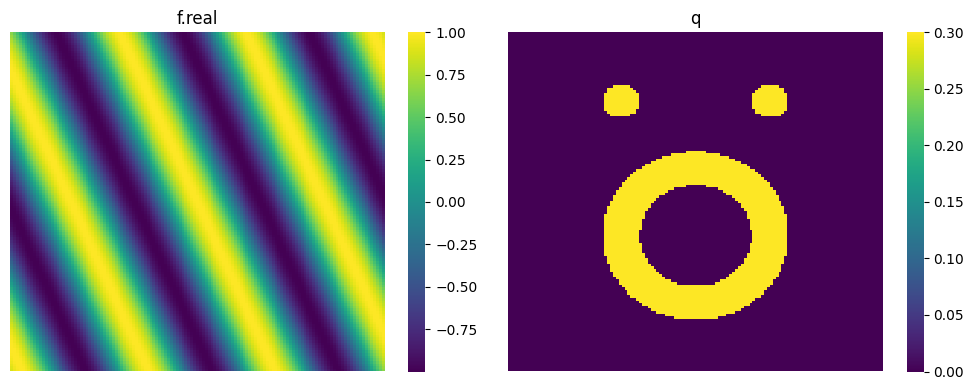

In [2]:
N = 128
k = 20
f = f_gen(N,k,16)[5]
q_init =0.3*q_gen(N,'T3')
heatmap_for_test(f.real,q_init,label_list=['f.real','q'],loss=False)

# Neumann Series
$$
\left\{\begin{array}{l}
\Delta u+k^2 u=-k^2 f \\
\lim _{r \rightarrow \infty} \sqrt{r}\left(\frac{\partial u}{\partial r}-i k u\right)=0
\end{array}\right.\\
\Rightarrow u = \hat{\mathcal{S}}(f)$$
$$
\left\{\begin{aligned}
u^{(1)} & \triangleq \hat{\mathcal{S}}\left(q u^i\right) \\
u^{(2)} & \triangleq \hat{\mathcal{S}}\left(q u^{(1)}\right) \\
& \cdots \\
u^{(j+1)} & \triangleq \hat{\mathcal{S}}\left(q u^{(j)}\right) \\
U^{(L)} & \triangleq \sum_{j=1}^L u^{(j)}
\end{aligned}\right.
$$

In [3]:
G, Matrix_Integral = Integral_Kernel(N, k)
%time u_I_0 = np.einsum('ijkl,kl->ij', G, Matrix_Integral*(-k*k*q_init*f))
u_I_1 = np.einsum('ijkl,kl->ij', G, Matrix_Integral*(-q_init*k*k*u_I_0))
u_I_2 = np.einsum('ijkl,kl->ij', G, Matrix_Integral*(-q_init*k*k*u_I_1))
u_I_3 = np.einsum('ijkl,kl->ij', G, Matrix_Integral*(-q_init*k*k*u_I_2))
u_I_4 = np.einsum('ijkl,kl->ij', G, Matrix_Integral*(-q_init*k*k*u_I_3))
u_I_5 = np.einsum('ijkl,kl->ij', G, Matrix_Integral*(-q_init*k*k*u_I_4))
u_I_6 = np.einsum('ijkl,kl->ij', G, Matrix_Integral*(-q_init*k*k*u_I_5))
u_I_7 = np.einsum('ijkl,kl->ij', G, Matrix_Integral*(-q_init*k*k*u_I_6))
u_I_8 = np.einsum('ijkl,kl->ij', G, Matrix_Integral*(-q_init*k*k*u_I_7))
u_I_9 = np.einsum('ijkl,kl->ij', G, Matrix_Integral*(-q_init*k*k*u_I_8))
print(np.linalg.norm(u_I_9))
u_t = u_I_0 + u_I_1 + u_I_2 + u_I_3 + u_I_4 + u_I_5 + u_I_6 + u_I_7 + u_I_8 + u_I_9

CPU times: user 463 ms, sys: 0 ns, total: 463 ms
Wall time: 463 ms
0.26844548388633954


## Absorbing Boundary Condition
($*$) is defined on $R^2$, we only focus on the solution restricted to $\Omega =[0,1]^2$.  
As a result, an absorbing boundary condition is introduced:
$$
\begin{aligned}
\Delta u^{(1)} + k^2(1+q) u^{(1)} &= -k^2qf \quad \text{in} \quad \Omega\\
\frac{\partial u^{(1)}}{\partial \nu} &= iku^{(1)}  \quad \text{on}\quad {\partial \Omega}\qquad \qquad(1)
\end{aligned}
$$
To make sure $u^{(1)}$ approximates $u_t$, the boundary to satisfies the robin boundary condition should be as outter as possible:
$$
\begin{aligned}
\Delta u^{(m)} + k^2(1+q^{(m)}) u^{(m)} &= -k^2q^{(m)}f^{(m)} \quad \text{in} \quad  \Omega_1 = [0,m]^2, m \in \mathbb{N}^{+}, m > 1\\
\frac{\partial u^{(m)}}{\partial \nu} &= iku^{(m)}  \quad \text{on}\quad {\partial \Omega_1}\qquad \qquad(2)
\end{aligned}
$$
Define $\Omega_2 = [\frac{m-1}{2},\frac{m+1}{2}]^2 \subset \Omega_1, q^{(m)}|_{\Omega_2} = q|_{\Omega},f^{(m)}|_{\Omega_2} = f|_{\Omega}$, then $u^{(m)}|_{\Omega_2}$ is a better approximation then $u^{(1)}|_{\Omega}$

CPU times: user 5.1 s, sys: 4.19 s, total: 9.28 s
Wall time: 4.57 s
CPU times: user 28.9 ms, sys: 0 ns, total: 28.9 ms
Wall time: 28.5 ms
相对误差为2.47%


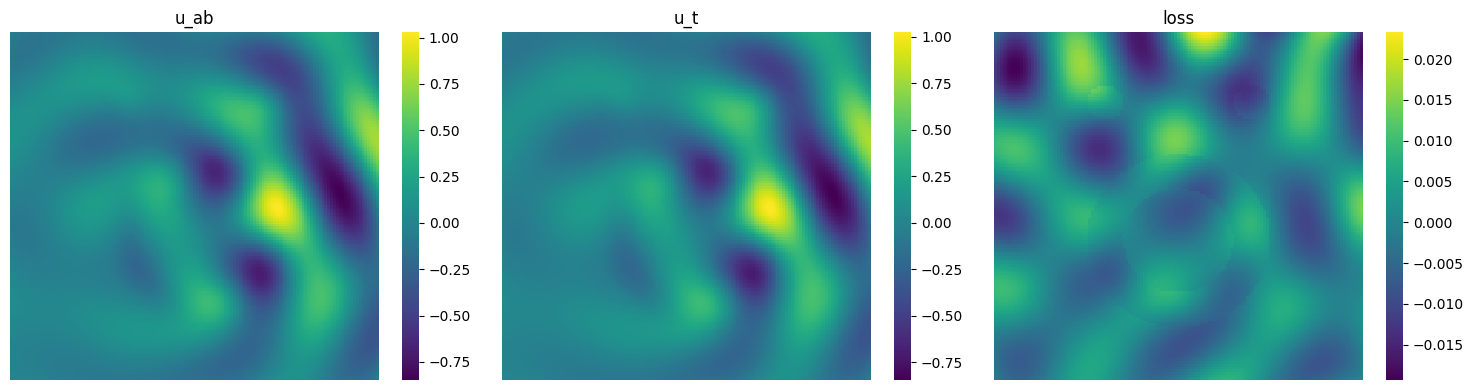

相对误差为2.20%


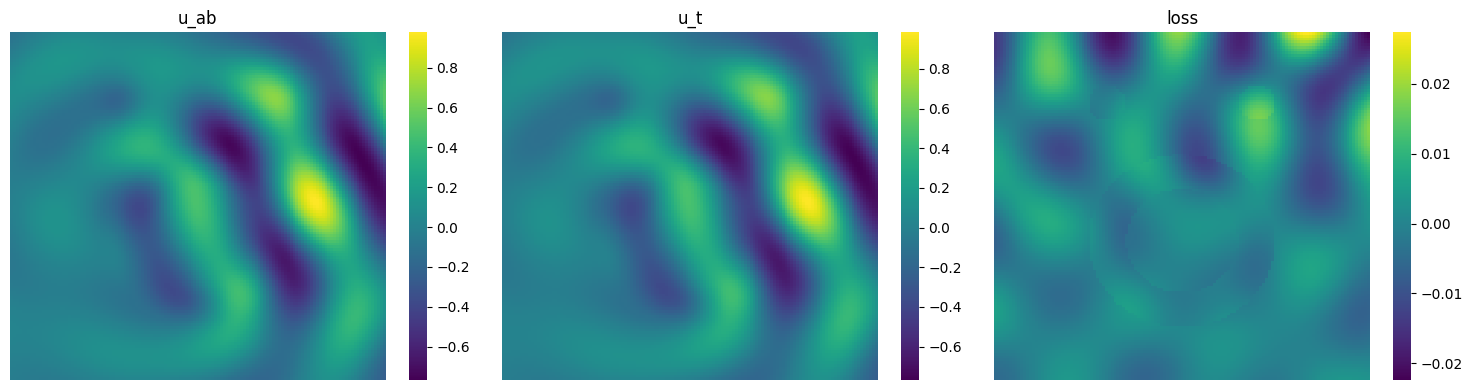

In [4]:
expand_times = 2
# %time Matrix_analysis(N,expand_times=expand_times)
%time Matrix_factorize_PETSC(N, k,q_init.reshape(-1,),expand_times=expand_times)
%time u_ab = Matrix_solve_PETSC(-(k*k*q_init*f).reshape(-1,),expand_times=expand_times).reshape(N+1,N+1)
heatmap_for_test(u_ab.real,u_t.real,label_list=['u_ab','u_t','loss'],loss=True)
heatmap_for_test(u_ab.imag,u_t.imag,label_list=['u_ab','u_t','loss'],loss=True)

## PML
$$
\begin{aligned}
\quad \Delta u + k^2(1+q)u= -k^2qf, \quad \text{in} \quad \mathbb{R}^2 \Rightarrow\\
\frac{\partial}{\partial x}(\frac{e_y}{e_x} \frac{\partial u}{\partial x})+
\frac{\partial}{\partial y}(\frac{e_x}{e_y} \frac{\partial u}{\partial y}) + e_x e_y k^2(1+q)u=-k^2qf \qquad (2)
\end{aligned}
$$
$$
\begin{aligned}
e_x = 1-i\frac{\sigma_x}{\omega},e_y = 1-i\frac{\sigma_y}{\omega},\omega = 2\pi f\\
\sigma_x:= \begin{cases}2 \pi a_0 f_0\left(\frac{l_\pi}{L_{P M L}}\right)^2, & \text { inside PML } \\ 0, & \text { outside PML }\end{cases}
\end{aligned}
$$
We want to get the solution restricted on $\Omega = [0,1]^2$.  
Suppose the thickness of PML: $L_{PML}$, $\Omega_3 = [0,2L_{PML}+1]^2,\Omega_4 = [L_{PML},L_{PML}+1]^2$  
We first solve (2) with dirichlet boundary condition on $\Omega_3$ and restrict it on $\Omega_4$ to approximate $u_t$

In [ ]:
thickness = 0.05
# %time Matrix_analysis(N,scheme='PML',thickness=thickness)
%time Matrix_factorize_PETSC(N, k,q_init.reshape(-1,),scheme='PML',thickness=thickness)
%time u_PML = Matrix_solve_PETSC(-(k*k*q_init*f).reshape(-1,),scheme='PML',thickness=thickness).reshape(N+1,N+1)
heatmap_for_test(u_PML.real,u_t.real,label_list=['u_PML','u_t','loss'],loss=True)
heatmap_for_test(u_PML.imag,u_t.imag,label_list=['u_PML','u_t','loss'],loss=True)

# Neumann Series

In [ ]:
def NS_l(q,l):
    Matrix_factorize_PETSC(N, k,q.reshape(-1,)*0,scheme='PML',thickness=thickness)
    u_NS_tmp = Matrix_solve_PETSC(-(k*k*q*f).reshape(-1,),scheme='PML',thickness=thickness).reshape(N+1,N+1)
    res = [u_NS_tmp]
    for i in range(l-1):
        u_NS_tmp = Matrix_solve_PETSC(-(k*k*q*u_NS_tmp).reshape(-1,),scheme='PML',thickness=thickness).reshape(N+1,N+1)
        res.append(u_NS_tmp)
    return res
u_NS = sum(NS_l(q_init,5))
heatmap_for_test(u_NS.real,u_t.real,label_list=['u_NS','u_t','loss'],loss=True)
heatmap_for_test(u_NS.imag,u_t.imag,label_list=['u_NS','u_t','loss'],loss=True)

# Convergence Born Series
$$
\left\{\begin{array}{l}
\Delta u+k^2(1+iM) u=-k^2 f \\
\lim _{r \rightarrow \infty} \sqrt{r}\left(\frac{\partial u}{\partial r}-i k u\right)=0
\end{array}\right.\\
\qquad \text{where} \qquad \|q\|_{\infty} \leq M\\
\Rightarrow u = \hat{\mathcal{T}}(f)
$$
       
$$
\left\{\begin{aligned}
u^{(1)} & \triangleq \frac{i}{M}(q-iM)\hat{\mathcal{T}}(qu^i)\\
u^{(2)} & \triangleq \frac{i}{M}((q-iM)\hat{\mathcal{T}}((q-iM)u^{(1)})-qu^{(1)})\\
u^{(3)} & \triangleq \frac{i}{M}((q-iM)\hat{\mathcal{T}}((q-iM)u^{(2)})-qu^{(2)})\\
& \cdots \\
u^{(j+1)} & \triangleq \frac{i}{M}((q-iM)\hat{\mathcal{T}}((q-iM)u^{(j)})-qu^{(j)})\\ \\
U^{(L)} & \triangleq \sum_{j=1}^L u^{(j)}
\end{aligned}\right.
$$

In [ ]:
def CBS_l(q,l,M):
    q1 = -1j*M*np.ones((N+1,N+1),dtype = np.complex128)
    # Matrix_analysis(N,scheme='PML',thickness=thickness,compl = True)
    Matrix_factorize_PETSC(N, k,q1.reshape(-1,),scheme='PML',thickness=thickness)
    u_CBS_tmp = (1j/M)*(q-1j*M)*(Matrix_solve_PETSC(-(k*k*q*f).reshape(-1,),scheme='PML',thickness=thickness).reshape(N+1,N+1))
    res = [u_CBS_tmp]
    for i in range(l-1):
        u_CBS_tmp = (1j/M)*((q-1j*M)*(Matrix_solve_PETSC(-k*k*((q-1j*M)*u_CBS_tmp).reshape(-1,),scheme='PML',thickness=thickness).reshape(N+1,N+1))-q*u_CBS_tmp)
        res.append(u_CBS_tmp)
    return res
u_CBS = sum(CBS_l(q_init,5,0.5))
heatmap_for_test(u_CBS.real,u_t.real,label_list=['u_CBS','u_t','loss'],loss=True)
heatmap_for_test(u_CBS.imag,u_t.imag,label_list=['u_CBS','u_t','loss'],loss=True)

# GMRES
$$
\left\{\begin{array}{l}
\Delta u+k^2u=k^2 f \\
\lim _{r \rightarrow \infty} \sqrt{r}\left(\frac{\partial u}{\partial r}-i k u\right)=0
\end{array}\right.\\
\qquad \text{where} \qquad \|q\|_{\infty} \leq M\\
\Rightarrow u \triangleq \hat{\mathcal{S}}(f)
$$
$$
\begin{aligned}
\Rightarrow (I+\hat{\mathcal{S}}(q\cdot))u &= \hat{\mathcal{S}}(-qf) \triangleq u_0\\
r_0 &= u_0 - (I+\hat{\mathcal{S}}(q\cdot))u_0 = -\hat{\mathcal{S}}(qu_0)\\
h_{1,0} &= \|r_0\|_2\\
v_1 & = r_0 / h_{1,0}\\
\text{for}\; & i = 1,2,\dots,k\\
& w_i = (I+\hat{\mathcal{S}}(q\cdot))v_i\\
& \text{for} \; j = 1,2,\dots,i\\
&\quad h_{j,i} = (w_i,v_j)\\
&\quad w_i = w_i - h_{j,i}v_j\\
&\text{end for}\\
&h_{i+1,i} = \|w_i\|_2\\
&v_{i+1} = w_i/h_{i+1,i}\\
&\text{Find}\; y_i \in R^{i} \text{ which minimizes} \|r_i\|_2 = \|\|r_0\|_2e_i-\bar{H_{i}}y\|_2\\
&x_i = x_0 + [v_1,\dots,v_i]y_i
\end{aligned}
$$

In [ ]:
def GS_l(q,l):
    res = []
    Matrix_factorize_PETSC(N, k,q.reshape(-1,)*0,scheme='PML',thickness=thickness)
    u_GS_0 = Matrix_solve_PETSC(-(k*k*q*f).reshape(-1,),scheme='PML',thickness=thickness).reshape(N+1,N+1)
    res.append(u_GS_0)
    l = l - 1
    
    if l > 0:
        r0 =  Matrix_solve_PETSC(-(k*k*q*u_GS_0).reshape(-1,),scheme='PML',thickness=thickness).reshape(N+1,N+1)
        h10 = np.linalg.norm(r0)
        v1 = r0/h10
        w1 = v1 + Matrix_solve_PETSC((k*k*q*v1).reshape(-1,),scheme='PML',thickness=thickness).reshape(N+1,N+1)
        h11 = np.sum(w1.real*v1.real + w1.imag*v1.imag)
        w1 = w1 - h11*v1
        h21 = np.linalg.norm(w1)
        v2 = w1/h21

        def f1(x):
            return (h11*x[0]-h10)**2 + h21*x[0]**2
        params1 = list(minimize(f1,[0]).x)
        u_GS_1 = u_GS_0+h10/h11*v1
        res.append(u_GS_1)
        l = l - 1

    if l > 0:
        w2 = v2 + Matrix_solve_PETSC((k*k*q*v2).reshape(-1,),scheme='PML',thickness=thickness).reshape(N+1,N+1)
        h12 = np.sum(v1.real*w2.real+v1.imag*w2.imag)
        w2 = w2 - h12*v1
        h22 = np.sum(v2.real*w2.real+v2.imag*w2.imag)
        w2 = w2 - h22*v2
        h32 = np.linalg.norm(w2)
        v3 = w2/h32

        def f2(x):
            return (h11*x[0]+h12*x[1]-h10)**2 + (h21*x[0]+h22*x[1])**2 + h32*x[1]**2
        params2 = list(minimize(f2,params1 +[0]).x)
        u_GS_2 = u_GS_0+params2[0]*v1+params2[1]*v2
        res.append(u_GS_2)
        l = l - 1
        
    if l > 0:
        w3 = v3 + Matrix_solve_PETSC((k*k*q*v3).reshape(-1,),scheme='PML',thickness=thickness).reshape(N+1,N+1)
        h13 = np.sum(v1.real*w3.real+v1.imag*w3.imag)
        w3 = w3 - h13*v1
        h23 = np.sum(v2.real*w3.real+v2.imag*w3.imag)
        w3 = w3 - h23*v2
        h33 = np.sum(v3.real*w3.real+v3.imag*w3.imag)
        w3 = w3 - h33*v3
        h43 = np.linalg.norm(w3)
        v4 = w3/h43

        def f3(x):
            return (h11*x[0]+h12*x[1]+h13*x[2]-h10)**2 + (h21*x[0]+h22*x[1]+h23*x[2])**2 + (h32*x[1] + h33*x[2])**2 + h43*x[2]**2
        params3 = list(minimize(f3,params2+[0]).x)
        u_GS_3 = u_GS_0+params3[0]*v1+params3[1]*v2+params3[2]*v3
        res.append(u_GS_3)
        l = l - 1
    
    if l > 0:
        w4 = v4 + Matrix_solve_PETSC((k*k*q*v4).reshape(-1,),scheme='PML',thickness=thickness).reshape(N+1,N+1)
        h14 = np.sum(v1.real*w4.real+v1.imag*w4.imag)
        w4 = w4 - h14*v1
        h24 = np.sum(v2.real*w4.real+v2.imag*w4.imag)
        w4 = w4 - h24*v2
        h34 = np.sum(v3.real*w4.real+v3.imag*w4.imag)
        w4 = w4 - h34*v3
        h44 = np.sum(v4.real*w4.real+v4.imag*w4.imag)
        w4 = w4 - h44*v4
        h54 = np.linalg.norm(w4)
        v5 = w4/h54

        def f4(x):
            return (h11*x[0]+h12*x[1]+h13*x[2] + h14*x[3]-h10)**2 + (h21*x[0]+h22*x[1]+h23*x[2] + h24*x[3])**2 \
                    + (h32*x[1] + h33*x[2] + h34*x[3])**2 + (h43*x[2]+h44*x[3])**2 + h54*x[3]**2
        params4 = list(minimize(f4,params3+[0]).x)
        u_GS_4 = u_GS_0+params4[0]*v1+params4[1]*v2+params4[2]*v3 + params4[3]*v4
        res.append(u_GS_4)
    
    return res

u_GS = GS_l(q_init,5)[-1]
heatmap_for_test(u_GS.real,u_t.real,label_list=['u_GS','u_t','loss'],loss=True)
heatmap_for_test(u_GS.imag,u_t.imag,label_list=['u_GS','u_t','loss'],loss=True)

# PLOT ERROR

In [ ]:
def ERROR(x,y):
    return np.linalg.norm(x-y)/np.linalg.norm(y)

def PLOT_CBS_ERROR(q,maxq, M_l):
    res = dict()
    q = q/q.max()*maxq
    Matrix_factorize_PETSC(N, k,q.reshape(-1,),scheme='PML',thickness=thickness)
    u_PML = Matrix_solve_PETSC(-(k*k*q*f).reshape(-1,),scheme='PML',thickness=thickness).reshape(N+1,N+1)
    for M in M_l:
        tmp = CBS_l(q,8,M)
        res[M] = [ERROR(sum(tmp[:i]),u_PML) for i in range(1,len(tmp)+1)]
    return res
CBS_res = PLOT_CBS_ERROR(q_init,0.3,[0.2,0.3,0.4,0.5,0.6])

In [ ]:
plt.figure(figsize=(8, 4))
y_min = 0.0
y_max = 0.6
def percentage_format(value, pos):
    return f'{value * 100:.0f}%'
formatter = FuncFormatter(percentage_format)
plt.ylim(y_min, y_max)
plt.gca().yaxis.set_major_formatter(formatter)
plt.gca().yaxis.set_major_locator(MultipleLocator(0.1))
plt.xlabel('Number of Iteration',fontsize=14)
plt.title('CBS, maxq = 0.3', fontsize=16)
x = list(range(1,9))
plt.plot(x,CBS_res[0.2],label='M=0.2',**plot_settings[0])
plt.plot(x,CBS_res[0.3],label='M=0.3',**plot_settings[1])
plt.plot(x,CBS_res[0.4],label='M=0.4',**plot_settings[2])
plt.plot(x,CBS_res[0.5],label='M=0.5',**plot_settings[3])
plt.plot(x,CBS_res[0.6],label='M=0.6',**plot_settings[4])
plt.legend()

In [ ]:
def PLOT_ERROR(q,method_l, maxq_l):
    res = dict()
    for maxq in maxq_l:
        tmp_d = dict()
        q1 = q/q.max()*maxq
        Matrix_factorize_PETSC(N, k,q1.reshape(-1,),scheme='PML',thickness=thickness)
        u_tmp = Matrix_solve_PETSC(-(k*k*q1*f).reshape(-1,),scheme='PML',thickness=thickness).reshape(N+1,N+1)        
        for method in method_l:
            if method == 'NS':
                tmp = NS_l(q1,5)
                tmp_d['NS'] = [ERROR(sum(tmp[:i]),u_tmp) for i in range(1,len(tmp)+1)]
            if method == 'CBS':
                tmp = CBS_l(q1,5,maxq)
                tmp_d['CBS'] = [ERROR(sum(tmp[:i]),u_tmp) for i in range(1,len(tmp)+1)]
            if method == 'GS':
                tmp = GS_l(q1,5)
                tmp_d['GS'] = [ERROR(_,u_tmp) for _ in tmp]
        res[maxq] = tmp_d
    return res
RESULT = PLOT_ERROR(q_init,['NS','CBS','GS'], [0.1,0.3,0.5])

In [ ]:
plt.figure(figsize=(8, 6))
y_min = 0.0
y_max = 0.6
def percentage_format(value, pos):
    return f'{value * 100:.0f}%'
formatter = FuncFormatter(percentage_format)
plt.ylim(y_min, y_max)
plt.gca().yaxis.set_major_formatter(formatter)
plt.gca().yaxis.set_major_locator(MultipleLocator(0.1))
plt.xlabel('Number of Iteration',fontsize=14)
plt.title('Results', fontsize=16)
x = list(range(1,6))
plt.plot(x,RESULT[0.1]['NS'],label='NS-0.1',color = 'r',ls = '-')
plt.plot(x,RESULT[0.1]['CBS'],label='CBS-0.1',color = 'g',ls = '-')
plt.plot(x,RESULT[0.1]['GS'],label='GS-0.1',color = 'b',ls = '-')
plt.plot(x,RESULT[0.3]['NS'],label='NS-0.3',color = 'r',ls = '--')
plt.plot(x,RESULT[0.3]['CBS'],label='CBS-0.3',color = 'g',ls = '--')
plt.plot(x,RESULT[0.3]['GS'],label='GS-0.3',color = 'b',ls = '--')
plt.plot(x,RESULT[0.5]['NS'],label='NS-0.5',color = 'r',ls = ':')
plt.plot(x,RESULT[0.5]['CBS'],label='CBS-0.5',color = 'g',ls = ':')
plt.plot(x,RESULT[0.5]['GS'],label='GS-0.5',color = 'b',ls = ':')
plt.legend()